In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.
File descriptions

    train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
    test.csv contains the test data.
    sample_submission.csv is submission file showing the correct format.

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from catboost import CatBoostClassifier
from catboost import Pool

from sklearn.model_selection import StratifiedKFold
import itertools
import math
import os

In [217]:
trainDir = '/tmp/porto/catboost/'

In [2]:
train = pd.read_csv('./data/train.csv',index_col='id')
test = pd.read_csv('./data/test.csv',index_col='id')

In [ ]:
for cName in train.columns.drop('target'):
    train.hist(bins=50,by = 'target',column = cName)
    plt.title(cName)

Категориальные фичи

In [ ]:
train.hist(bins=50,by = 'target',column = 'ps_ind_11_bin')

In [ ]:
sns.factorplot(x="ps_ind_03", col="target", data=train, kind="count", size=4, aspect=.7);

In [ ]:
sns.violinplot(x="ps_ind_03", hue="target", data=train, palette="muted", split=True)

Классы несбалансированы

Посмотреть на корреляцию данных и целевой переменной

In [ ]:
train.hist(by='target')

In [ ]:
ax = sns.violinplot(x="day", y="total_bill", hue="smoker",
...                     data=tips, palette="muted", split=True)

# CatBoost

In [ ]:
trainPool = Pool(train.drop('target',axis = 1),train.target)
testPool  = Pool(test)

# specify the training parameters 
model = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.05, loss_function='Logloss',thread_count=6)
#train the model
model.fit(trainPool,verbose=True, plot=True)

In [ ]:
# make the prediction using the resulting model
preds = model.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

score 0.274

## Балансировка классов

In [ ]:
# specify the training parameters 
model2 = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.05, loss_function='Logloss',thread_count=6,class_weights=[0.2, 0.8])
#train the model
model2.fit(trainPool,verbose=True, plot=True)

In [ ]:
# make the prediction using the resulting model
preds = model2.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

In [ ]:
model2.save_model('model2.cbm')

score 0.270

# Investigate some ideas from kaggle's forum

# column ps_car_15
Column "ps_car_15" contains below unique values, which are square roots of integer 0 ~ 14. Is it devised deliberately? It looks non-sense.

In [5]:
def modCat15(df):
    return df.assign(ps_car_15_mod = np.power(df.ps_car_15,2).astype(int))

In [ ]:
trainPool = Pool(train.drop('target',axis = 1),train.target)
testPool  = Pool(test)

# specify the training parameters 
model = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.05, loss_function='Logloss',thread_count=6)
#train the model
model.fit(trainPool,verbose=True, plot=True)

Скор 0.271, что соевсем не улучшило предыдущий результат. В тоже время последняя загрузка давала 0.270. Возможно, дело в скорости обучения. Поставлю дефолтное значение. 
<ul> Идеи, что можно проверить и поделать
<li> Задавать параметр "категориальные значения" для категориальных.
<li> Подбор гиперпарамеров
<li> Сделать оценку целевой метрики Джини
<li> Feature engineering
<li> Перевести one-hot-endoded в категориальные переменные, поставить их как категории
</ul> 

In [6]:
X_train = modCat15(train.drop('target',axis = 1))
y_train = train.target

In [ ]:
trainPool = Pool(X_train,y_train,
                 feature_names=X_train.columns.tolist())

In [ ]:
X_test = modCat15(test)
testPool = Pool(X_test,feature_names=X_train.columns.tolist())

In [ ]:
# specify the training parameters 
model = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.03, loss_function='Logloss',thread_count=6)
#train the model
model.fit(trainPool,verbose=True, plot=True)

# make the prediction using the resulting model
preds = model.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

Скор 0.274, как и был. То есть квадрат категории ps_car_15 ничего не даёт

In [245]:
# Распарсим имена фич и все с суффиксом cat запишем в категориальные, получим их номера и будем 

def getCatFeatures(featureList):
    '''
    featureList is list of features name (df.columns.tolist())
    '''
    catFeatures = []
    for featureInd, featureName in enumerate(featureList):
        if featureName[-3:] == 'cat':
            catFeatures.append(featureInd)
            
    return catFeatures      

In [ ]:
catFeatures = getCatFeatures(X_train.columns.tolist())
catFeatures 

In [ ]:
y_train = train.target
trainPool = Pool(X_train,y_train, feature_names=X_train.columns.tolist(),cat_features= catFeatures)

In [ ]:
testPool = Pool(X_test, feature_names=X_train.columns.tolist(), cat_features= catFeatures)

# specify the training parameters 
model = CatBoostClassifier(iterations=3000, depth=10, learning_rate=0.03, loss_function='Logloss',thread_count=6)
#train the model
model.fit(trainPool,verbose=True, plot=True)

# make the prediction using the resulting model
preds = model.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

Улучшил скор на 0,002. Возможно, сыграла свою роль случайность сида в random генераторе.

Переход на 3000 итераций не дал улучшений.

In [ ]:
coeffs = model.get_feature_importance(trainPool, cat_features= catFeatures, thread_count=4, fstr_type='FeatureImportance')

In [ ]:
inds = np.argsort(np.array(coeffs))

plt.figure(figsize = [15,20])

plt.barh(range(len(coeffs)),np.array(coeffs)[inds], tick_label = np.array(X_train.columns.tolist())[inds],
        color="r", align="center")
plt.ylim([-1, X_train.shape[1]])

Виден резкий скачок в значимости параметров для последний 12 категорий

ps_calc_15,16,17,18,19,20_bin

ps_ind_10,11,12,13_bin

ps_ind_14

that is, you won't find a row where more than one of [ps_ind_06,ps_ind_07,ps_ind_08,ps_ind_09] is True. 

Может быть ps_calc_15_30- тоже one-hot-encoding?
Совсем нет ((

In [ ]:
np.unique(X_train.ps_ind_06_bin+X_train.ps_ind_07_bin+X_train.ps_ind_08_bin+X_train.ps_ind_09_bin)

In [3]:
def invOneHot(df):
    tmp = df.assign(ps_ind_69_cat = 0*df.ps_ind_06_bin+df.ps_ind_07_bin+2*df.ps_ind_08_bin+3*df.ps_ind_09_bin)
    tmp.drop(['ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin'],inplace=True,axis = 1)
    return tmp

In [7]:
X_train2 = invOneHot(X_train)

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,...,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_15_mod,ps_ind_69_cat
id,,,,,,,,,,,,,,,,,,,,,
7,2,2,5,1,0,0,0,0,0,0,...,5,8,0,1,1,0,0,1,13,1
9,1,1,7,0,0,0,0,0,0,0,...,1,9,0,1,1,0,1,0,6,2
13,5,4,9,1,0,0,0,0,0,0,...,7,7,0,1,1,0,1,0,11,2
16,0,1,2,0,0,0,0,0,0,0,...,4,9,0,0,0,0,0,0,4,0
17,0,2,0,1,0,0,0,0,0,0,...,1,3,0,0,0,1,1,0,4,0


In [12]:
X_train2 = invOneHot(X_train)
tp = Pool(X_train2,y_train,feature_names=X_train2.columns.tolist())

In [35]:
model5 = CatBoostClassifier(verbose=True,iterations=500)

In [36]:
model5.fit(tp)

Borders for float features generated
0:	learn 0.6484665849	total: 512ms	remaining: 4m 15s
1:	learn 0.6075430241	total: 1.01s	remaining: 4m 10s
2:	learn 0.5701063869	total: 1.48s	remaining: 4m 5s
3:	learn 0.53569801	total: 1.92s	remaining: 3m 57s
4:	learn 0.5043244463	total: 2.38s	remaining: 3m 55s
5:	learn 0.4755537023	total: 2.81s	remaining: 3m 51s
6:	learn 0.449189969	total: 3.22s	remaining: 3m 46s
7:	learn 0.4252023207	total: 3.68s	remaining: 3m 46s
8:	learn 0.4032925531	total: 4.16s	remaining: 3m 47s
9:	learn 0.3831429331	total: 4.61s	remaining: 3m 46s
10:	learn 0.3647294409	total: 5.33s	remaining: 3m 57s
11:	learn 0.3478762585	total: 5.94s	remaining: 4m 1s
12:	learn 0.332580569	total: 6.36s	remaining: 3m 58s
13:	learn 0.3184402244	total: 6.85s	remaining: 3m 57s
14:	learn 0.3054687919	total: 7.33s	remaining: 3m 57s
15:	learn 0.2936794975	total: 7.8s	remaining: 3m 56s
16:	learn 0.2827595843	total: 8.23s	remaining: 3m 53s
17:	learn 0.2728101417	total: 8.65s	remaining: 3m 51s
18:	lear

152:	learn 0.1523411978	total: 1m 18s	remaining: 2m 57s
153:	learn 0.1523305053	total: 1m 18s	remaining: 2m 56s
154:	learn 0.1523177655	total: 1m 19s	remaining: 2m 55s
155:	learn 0.152303176	total: 1m 20s	remaining: 2m 57s
156:	learn 0.1522891779	total: 1m 21s	remaining: 2m 58s
157:	learn 0.1522781048	total: 1m 22s	remaining: 2m 57s
158:	learn 0.1522725865	total: 1m 22s	remaining: 2m 56s
159:	learn 0.1522636741	total: 1m 22s	remaining: 2m 56s
160:	learn 0.1522528641	total: 1m 23s	remaining: 2m 56s
161:	learn 0.1522441462	total: 1m 25s	remaining: 2m 58s
162:	learn 0.1522379531	total: 1m 27s	remaining: 3m
163:	learn 0.1522337874	total: 1m 29s	remaining: 3m 2s
164:	learn 0.1522245759	total: 1m 29s	remaining: 3m 1s
165:	learn 0.1522120319	total: 1m 29s	remaining: 3m
166:	learn 0.1522022791	total: 1m 30s	remaining: 3m
167:	learn 0.1521926901	total: 1m 31s	remaining: 3m
168:	learn 0.15218465	total: 1m 31s	remaining: 2m 59s
169:	learn 0.1521766903	total: 1m 32s	remaining: 2m 58s
170:	learn 0.

300:	learn 0.1514137501	total: 3m 7s	remaining: 2m 4s
301:	learn 0.1514104719	total: 3m 8s	remaining: 2m 3s
302:	learn 0.1514060034	total: 3m 8s	remaining: 2m 2s
303:	learn 0.1514030667	total: 3m 9s	remaining: 2m 1s
304:	learn 0.1513979672	total: 3m 9s	remaining: 2m 1s
305:	learn 0.1513957844	total: 3m 11s	remaining: 2m 1s
306:	learn 0.1513926879	total: 3m 11s	remaining: 2m
307:	learn 0.1513861244	total: 3m 12s	remaining: 1m 59s
308:	learn 0.151380506	total: 3m 12s	remaining: 1m 59s
309:	learn 0.1513745587	total: 3m 13s	remaining: 1m 58s
310:	learn 0.1513703364	total: 3m 14s	remaining: 1m 57s
311:	learn 0.1513658336	total: 3m 14s	remaining: 1m 57s
312:	learn 0.1513634095	total: 3m 15s	remaining: 1m 56s
313:	learn 0.1513605376	total: 3m 15s	remaining: 1m 55s
314:	learn 0.1513582782	total: 3m 15s	remaining: 1m 55s
315:	learn 0.1513529748	total: 3m 16s	remaining: 1m 54s
316:	learn 0.1513480813	total: 3m 16s	remaining: 1m 53s
317:	learn 0.1513454186	total: 3m 17s	remaining: 1m 52s
318:	lea

449:	learn 0.1508622922	total: 4m 19s	remaining: 28.8s
450:	learn 0.1508573844	total: 4m 19s	remaining: 28.2s
451:	learn 0.1508525001	total: 4m 20s	remaining: 27.6s
452:	learn 0.1508487602	total: 4m 20s	remaining: 27.1s
453:	learn 0.1508445863	total: 4m 21s	remaining: 26.5s
454:	learn 0.1508391434	total: 4m 21s	remaining: 25.9s
455:	learn 0.1508360688	total: 4m 22s	remaining: 25.3s
456:	learn 0.1508320357	total: 4m 22s	remaining: 24.7s
457:	learn 0.1508274665	total: 4m 23s	remaining: 24.1s
458:	learn 0.1508234867	total: 4m 23s	remaining: 23.5s
459:	learn 0.1508196576	total: 4m 23s	remaining: 22.9s
460:	learn 0.1508163214	total: 4m 24s	remaining: 22.4s
461:	learn 0.1508115704	total: 4m 24s	remaining: 21.8s
462:	learn 0.1508068551	total: 4m 25s	remaining: 21.2s
463:	learn 0.1508022678	total: 4m 25s	remaining: 20.6s
464:	learn 0.1507991653	total: 4m 26s	remaining: 20s
465:	learn 0.1507972372	total: 4m 26s	remaining: 19.5s
466:	learn 0.1507931899	total: 4m 27s	remaining: 18.9s
467:	learn 0

In [22]:
def plotFeatureImportance(cfs,df_col_name):
    inds = np.argsort(np.array(cfs))
    
    kArr = np.array(df_col_name)[inds]
    vArr = np.array(cfs)[inds]
    
    res = {k:v for (k,v) in zip(kArr,vArr)}
    
    plt.figure(figsize = [15,20])
    plt.barh(range(len(cfs)), vArr, tick_label = kArr, color="r", align="center")
    plt.ylim([-1, X_train.shape[1]])
    
    return res

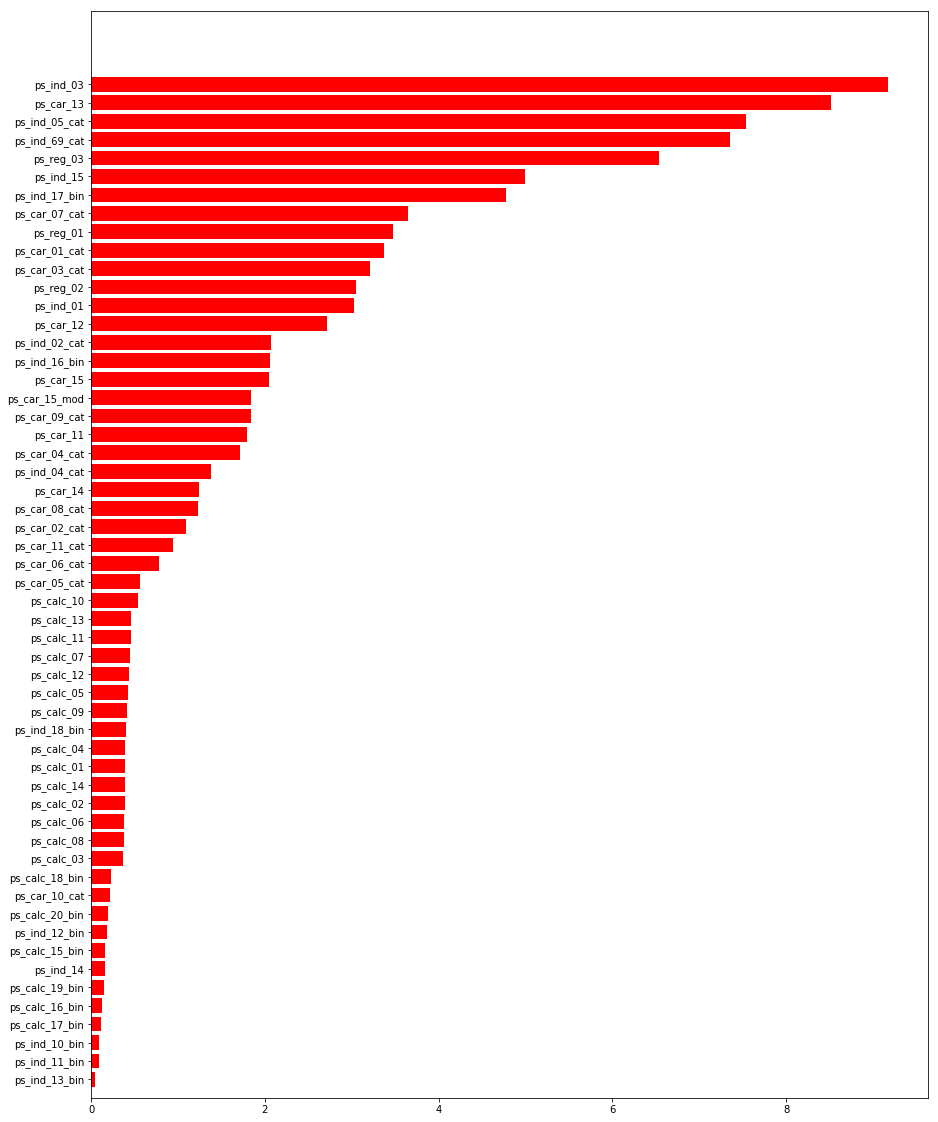

In [37]:
coeffs2 = model5.get_feature_importance(tp)
cDict = plotFeatureImportance(coeffs2,X_train2.columns.tolist())

In [38]:
cDict.get('ps_ind_69_cat')

7.3520621444403762

In [94]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)
 
def test_gini():
    def fequ(a,b):
        return abs( a -b) < 1e-6

    def T(a, p, g, n):
        assert( fequ(gini(a,p), g) )
        assert( fequ(gini_normalized(a,p), n) )
     
    T([1, 2, 3], [10, 20, 30], 0.111111, 1)
    T([1, 2, 3], [30, 20, 10], -0.111111, -1)
    T([1, 2, 3], [0, 0, 0], -0.111111, -1)
    T([3, 2, 1], [0, 0, 0], 0.111111, 1)
    T([1, 2, 4, 3], [0, 0, 0, 0], -0.1, -0.8)
    T([2, 1, 4, 3], [0, 0, 2, 1], 0.125, 1)
    T([0, 20, 40, 0, 10], [40, 40, 10, 5, 5], 0, 0)
    T([40, 0, 20, 0, 10], [1000000, 40, 40, 5, 5], 0.171428, 0.6)
    T([40, 20, 10, 0, 0], [40, 20, 10, 0, 0], 0.285714, 1)
    T([1, 1, 0, 1], [0.86, 0.26, 0.52, 0.32], -0.041666, -0.333333)

In [43]:
X_test2 = invOneHot(modCat15(test))
tp2 = Pool(X_test2, feature_names=X_test2.columns.tolist())

# make the prediction using the resulting model
preds = model5.predict_proba(tp2)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

In [51]:
## pipeline

# prepare data
X_train = invOneHot(modCat15(train.drop('target',axis = 1)))
y_train = train.target
X_test = invOneHot(modCat15(test))

In [179]:
class GiniMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is list of indexed containers (containers with only __len__ and __getitem__ defined), one container
        # per approx dimension. Each container contains floats.
        # weight is one dimensional indexed container.
        # target is float.
        
        # weight parameter can be None.
        # Returns pair (error, weights sum)
        
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        

        t = np.array(target)
        a = np.array(approxes[0])

        error_sum = 0.0
        weight_sum = 0.0
        
        g = gini_normalized(t,a)

        return g, 1   

In [206]:
fullPool = Pool(X_train, y_train, feature_names=X_train.columns.tolist())

In [209]:
testPool = Pool(X_test, feature_names=X_train.columns.tolist())

In [225]:
tModel = CatBoostClassifier(verbose=True, iterations=200, thread_count=4, random_seed=42, eval_metric= GiniMetric(),
                                   depth=14, learning_rate=0.03, l2_leaf_reg= 3, bagging_temperature=1)

In [226]:
tModel.fit(fullPool,verbose=True)

Borders for float features generated
0:	learn 0.1562063467	total: 8.06s	remaining: 26m 44s
1:	learn 0.1793790157	total: 9.12s	remaining: 15m 2s
2:	learn 0.1793076484	total: 9.82s	remaining: 10m 45s
3:	learn 0.2191870035	total: 10.9s	remaining: 8m 52s
4:	learn 0.22808223	total: 12.1s	remaining: 7m 52s
5:	learn 0.2295418276	total: 13.4s	remaining: 7m 11s
6:	learn 0.2459253877	total: 21.2s	remaining: 9m 43s
7:	learn 0.2592813615	total: 29.1s	remaining: 11m 38s
8:	learn 0.2665079126	total: 33s	remaining: 11m 40s
9:	learn 0.2667396396	total: 33.8s	remaining: 10m 41s
10:	learn 0.2684079786	total: 35s	remaining: 10m 1s
11:	learn 0.2766424293	total: 42.9s	remaining: 11m 12s
12:	learn 0.2789818905	total: 43.9s	remaining: 10m 31s
13:	learn 0.2804050652	total: 46.3s	remaining: 10m 15s
14:	learn 0.2838674233	total: 47.7s	remaining: 9m 48s
15:	learn 0.2852044663	total: 49.2s	remaining: 9m 26s
16:	learn 0.2892131905	total: 57.3s	remaining: 10m 16s
17:	learn 0.2912930732	total: 58.5s	remaining: 9m 51

149:	learn 0.3230867265	total: 7m 49s	remaining: 2m 36s
150:	learn 0.3251435542	total: 7m 56s	remaining: 2m 34s
151:	learn 0.326053098	total: 8m 4s	remaining: 2m 32s
152:	learn 0.3260143786	total: 8m 5s	remaining: 2m 29s
153:	learn 0.3285405043	total: 8m 13s	remaining: 2m 27s
154:	learn 0.3296245674	total: 8m 20s	remaining: 2m 25s
155:	learn 0.3306439013	total: 8m 28s	remaining: 2m 23s
156:	learn 0.3306416173	total: 8m 29s	remaining: 2m 19s
157:	learn 0.331033936	total: 8m 30s	remaining: 2m 15s
158:	learn 0.3332706801	total: 8m 32s	remaining: 2m 12s
159:	learn 0.3331595318	total: 8m 32s	remaining: 2m 8s
160:	learn 0.3332700701	total: 8m 33s	remaining: 2m 4s
161:	learn 0.3334420149	total: 8m 35s	remaining: 2m
162:	learn 0.3367401322	total: 8m 43s	remaining: 1m 58s
163:	learn 0.337002777	total: 8m 51s	remaining: 1m 56s
164:	learn 0.3376999942	total: 8m 59s	remaining: 1m 54s
165:	learn 0.3376605412	total: 9m	remaining: 1m 50s
166:	learn 0.3382549339	total: 9m 8s	remaining: 1m 48s
167:	lea

In [227]:
# make the prediction using the resulting model
preds = tModel.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

In [228]:
# prepare params
depth = [14] # depth of trees
rate  = [0.07, 0.1, 0.01, 0.03]; # learning rate
l2    = [1, 3, 5, 10]; # l2_leaf_reg
T = [1]; # bagging_temperature
pr = itertools.product(depth, rate, l2, T)

In [246]:
catFeatures = getCatFeatures(X_train)

In [ ]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best = 0
pr = itertools.product(depth, rate, l2, T)

for params in pr:
    print params
    
    giniList = list()
    nEpoch = 150
    modelList = list()


    dirName = '/tmp/porto/catboost/'+str(params[0])+'_'+str(params[1])+'_'+str(params[2])+'_'+str(params[3])
    os.mkdir(dirName)
    
    ind = 0;
    
    for train_index, val_index in skf.split(X_train, y_train):
        ind = ind +1   
            
        model = CatBoostClassifier(verbose=True, iterations=nEpoch, thread_count=4, random_seed=42,
                                   depth=params[0], learning_rate=params[1],
                                   l2_leaf_reg=params[2], bagging_temperature=params[3],
                                   eval_metric= GiniMetric(), train_dir = dirName+'/'+str(ind),
                                   od_type = 'Iter', od_wait = 20)
        
        trainPool = Pool(X_train.iloc[train_index], y_train.iloc[train_index],
                         feature_names=X_train.columns.tolist(), cat_features= catFeatures)
        valPool   = Pool(X_train.iloc[val_index],   y_train.iloc[val_index], 
                         feature_names=X_train.columns.tolist(), cat_features= catFeatures) 

        model.fit(trainPool, eval_set=valPool, use_best_model = True)
        nEpoch = model.tree_count_ + 20
        modelList.append(model)
        
        c = model.predict(valPool,prediction_type='Probability')[:,1]
        g = gini_normalized(y_train.iloc[val_index], c)
        giniList.append(g)

    print giniList
    meanGini = np.array(giniList).mean()
    print 'Gini',meanGini
    
    if meanGini>best:
        best = meanGini
        
        bestList = modelList
        bestParams = params
        #bestModel.save_model('bestModel3.cbm')
        print 'Rewrite best model'

(14, 0.07, 1, 1)
Borders for float features generated
0:	learn 0.05415180668	test 0.04222790496	bestTest 0.04222790496		total: 1.55s	remaining: 3m 51s
1:	learn 0.114195394	test 0.1056244298	bestTest 0.1056244298		total: 2.98s	remaining: 3m 40s
2:	learn 0.1440206674	test 0.1245645254	bestTest 0.1245645254		total: 6.16s	remaining: 5m 1s
3:	learn 0.1609792412	test 0.1462529718	bestTest 0.1462529718		total: 22.6s	remaining: 13m 45s
4:	learn 0.1609792412	test 0.1462529718	bestTest 0.1462529718		total: 23.2s	remaining: 11m 12s
5:	learn 0.1786656054	test 0.1614494195	bestTest 0.1614494195		total: 26.3s	remaining: 10m 30s
6:	learn 0.1935330046	test 0.1768247941	bestTest 0.1768247941		total: 28.6s	remaining: 9m 44s
7:	learn 0.1935719898	test 0.1768505847	bestTest 0.1768505847		total: 29.4s	remaining: 8m 42s
8:	learn 0.1935687831	test 0.1768505847	bestTest 0.1768505847		total: 30.3s	remaining: 7m 54s
9:	learn 0.1935778325	test 0.1768505847	bestTest 0.1768505847		total: 31.2s	remaining: 7m 16s
10

86:	learn 0.287950947	test 0.2422902975	bestTest 0.2422902975		total: 6m 21s	remaining: 4m 35s
87:	learn 0.2880436894	test 0.2424842333	bestTest 0.2424842333		total: 6m 24s	remaining: 4m 30s
88:	learn 0.2887095084	test 0.2423904983	bestTest 0.2424842333		total: 6m 27s	remaining: 4m 25s
89:	learn 0.2890415903	test 0.2428647351	bestTest 0.2428647351		total: 6m 28s	remaining: 4m 18s
90:	learn 0.289457751	test 0.2428258121	bestTest 0.2428647351		total: 6m 45s	remaining: 4m 23s
91:	learn 0.2903620393	test 0.2431812748	bestTest 0.2431812748		total: 6m 50s	remaining: 4m 18s
92:	learn 0.2908372156	test 0.2429752875	bestTest 0.2431812748		total: 7m 7s	remaining: 4m 21s
93:	learn 0.2912717728	test 0.2428933347	bestTest 0.2431812748		total: 7m 21s	remaining: 4m 23s
94:	learn 0.2916904924	test 0.2432959542	bestTest 0.2432959542		total: 7m 23s	remaining: 4m 16s
95:	learn 0.2924875046	test 0.2436832995	bestTest 0.2436832995		total: 7m 26s	remaining: 4m 11s
96:	learn 0.2949044617	test 0.2437326263	be

20:	learn 0.2229991038	test 0.219377561	bestTest 0.219377561		total: 57.4s	remaining: 6m 11s
21:	learn 0.2291308719	test 0.2259966561	bestTest 0.2259966561		total: 59.5s	remaining: 6m 4s
22:	learn 0.2292304944	test 0.2259876427	bestTest 0.2259966561		total: 1m 19s	remaining: 7m 45s
23:	learn 0.2317831164	test 0.2295990625	bestTest 0.2295990625		total: 1m 24s	remaining: 7m 49s
24:	learn 0.2315379659	test 0.2285403176	bestTest 0.2295990625		total: 1m 43s	remaining: 9m 4s
25:	learn 0.2336720756	test 0.2313275633	bestTest 0.2313275633		total: 1m 44s	remaining: 8m 44s
26:	learn 0.239359193	test 0.2368536641	bestTest 0.2368536641		total: 1m 49s	remaining: 8m 47s
27:	learn 0.2399481098	test 0.2376181678	bestTest 0.2376181678		total: 1m 52s	remaining: 8m 36s
28:	learn 0.2405652557	test 0.2384401157	bestTest 0.2384401157		total: 1m 55s	remaining: 8m 28s
29:	learn 0.2403362492	test 0.2379032669	bestTest 0.2384401157		total: 1m 57s	remaining: 8m 16s
30:	learn 0.2412225047	test 0.2386814736	bestTe

thread_count = None

    CPU times: user 18min 29s, sys: 38.6 s, total: 19min 7s
    Wall time: 3min 52s
    
thread_count = 4

    CPU times: user 12min 44s, sys: 22.3 s, total: 13min 7s
    Wall time: 4min 44s
    
thread_count = 8
 
    CPU times: user 18min 32s, sys: 38.3 s, total: 19min 10s
    Wall time: 3min 53s
  

Модель с большей глубиной деревьев явно даёт лучший скор. Пожалуй, не стоит даже тратить время на разбор модели глубиной в 6 уровней.

(6, 0.01, 0.1, 0)
Gini 0.262343767754
Rewrite best model
(6, 0.01, 0.1, 0.5)
Gini 0.262081415805
(6, 0.01, 0.1, 1)
Gini 0.262421209745
Rewrite best model
(6, 0.01, 1, 0)
Gini 0.262848420139
Rewrite best model
(6, 0.01, 1, 0.5)
Gini 0.2626839012
(6, 0.01, 1, 1)
Gini 0.263138501204
Rewrite best model
(6, 0.01, 3, 0)
Gini 0.263209802969
Rewrite best model
(6, 0.01, 3, 0.5)
Gini 0.26342563872
Rewrite best model
(6, 0.01, 3, 1)
Gini 0.263588996931
Rewrite best model
(6, 0.01, 5, 0)
Gini 0.263425065333
(6, 0.01, 5, 0.5)
Gini 0.263394031391
(6, 0.01, 5, 1)
Gini 0.264035888306
Rewrite best model
(6, 0.01, 10, 0)
Gini 0.263506118925
(6, 0.01, 10, 0.5)

(14, 0.01, 0.1, 0)
Gini 0.262986796172
Rewrite best model

Обучение на модели глубиной в 16 деревьев дало скор хуже - 0.266
Похоже, что модель переобучается. Щас мы это дело пофиксим